## Dataset define

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd

df_train = pd.read_csv("/content/imdb_train.csv")
df_val = pd.read_csv("/content/imdb_validation.csv")
df_test = pd.read_csv("/content/imdb_test.csv")

In [10]:
df_train.head()

,text,label
0,"It's a Time Machine all right. It runs in ""rea...",0
1,Recognizing the picture of the diner on the co...,0
2,"Hmm, Hip Hop music to a period western. Modern...",0
3,"This is a formula B science fiction movie, and...",0
4,Strange yet emotionally disturbing chiller abo...,1


## Model define

In [12]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### dataset and dataloader split

In [13]:
from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.texts = dataframe["text"].tolist()
        self.labels = dataframe["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {key: val.squeeze(0) for key, val in encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


In [32]:
from transformers import AutoTokenizer

batch_size = 16
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = IMDBDataset(df_train, tokenizer)
val_dataset = IMDBDataset(df_val, tokenizer)
test_dataset = IMDBDataset(df_test, tokenizer)

print("Train samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

Train samples: 35000
Validation samples: 10000
Test samples: 5000


In [34]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print("Number of batches in train_dataloader:", len(train_dataloader))
print("Number of batches in val_dataloader:", len(val_dataloader))
print("Number of batches in test_dataloader:", len(test_dataloader))

Number of batches in train_dataloader: 2188
Number of batches in val_dataloader: 625
Number of batches in test_dataloader: 313


### optimizer and loss set

In [38]:
from transformers import get_scheduler
from torch.optim import AdamW
import torch

optimizer = AdamW(model.parameters(), lr=2e-5)

# 使用 GPU 如果可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 训练步数
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)

# 学习率调度器（线性 warmup）
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

In [37]:
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

loss_fn = CrossEntropyLoss()

## Train and evaluate

### train function

In [39]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score


def train(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, device, num_epochs=3):
    model.train()

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        total_loss = 0
        all_preds = []
        all_labels = []

        # Training Loop
        model.train()
        loop = tqdm(train_dataloader, desc="Training")

        for batch in loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            # Backward
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            # Metrics
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(batch['labels'].detach().cpu().numpy())

        train_acc = accuracy_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds)

        print(f"Train Loss: {total_loss:.4f} | Accuracy: {train_acc:.4f} | F1: {train_f1:.4f}")

        # Validation Loop
        evaluate(model, val_dataloader, device)


@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(batch['labels'].detach().cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

In [40]:
train(model, train_dataloader, val_dataloader, optimizer, lr_scheduler, device, num_epochs=3)


Epoch 1/3


Training: 100%|██████████| 2188/2188 [25:14<00:00,  1.45it/s]


Train Loss: 541.3750 | Accuracy: 0.8988 | F1: 0.8983
Validation Accuracy: 0.9204 | F1 Score: 0.9238

Epoch 2/3


Training: 100%|██████████| 2188/2188 [25:11<00:00,  1.45it/s]


Train Loss: 272.7634 | Accuracy: 0.9554 | F1: 0.9551
Validation Accuracy: 0.9232 | F1 Score: 0.9263

Epoch 3/3


Training: 100%|██████████| 2188/2188 [25:11<00:00,  1.45it/s]


Train Loss: 111.0658 | Accuracy: 0.9851 | F1: 0.9851
Validation Accuracy: 0.9258 | F1 Score: 0.9283


### test function

In [41]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

@torch.no_grad()
def final_evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {acc:.4f} | F1 Score: {f1:.4f}")

    # 混淆矩阵可视化
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

✅ Test Accuracy: 0.9372 | F1 Score: 0.9373


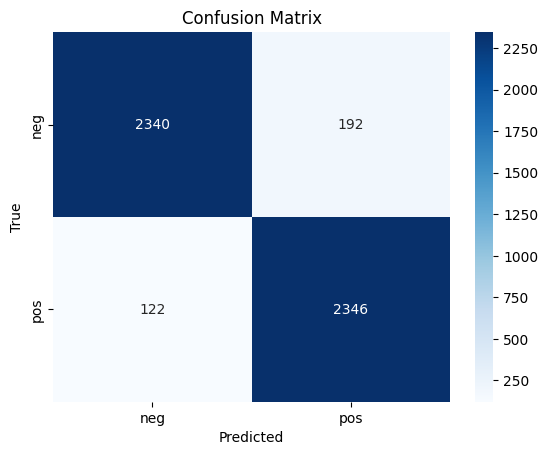

In [43]:
final_evaluate(model, test_dataloader, device)

## Save model and tokenizer

In [44]:
torch.save(model.state_dict(), "bert_base.pt")

# from transformers import BertForSequenceClassification

# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.load_state_dict(torch.load("bert_sentiment.pt", map_location=device))
# model.to(device)
# model.eval()


tokenizer.save_pretrained("bert_base_tokenizer/")

# from transformers import AutoTokenizer
# tokenizer = AutoTokenizer.from_pretrained("bert_tokenizer/")

('bert_base_tokenizer/tokenizer_config.json',
 'bert_base_tokenizer/special_tokens_map.json',
 'bert_base_tokenizer/vocab.txt',
 'bert_base_tokenizer/added_tokens.json',
 'bert_base_tokenizer/tokenizer.json')